# Hybrid linear and symbolic regression

In this notebook, we'll go over our approach to symbolic regression with spatial derivatives and linear regression for fitting outer constants.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg
import json
import fsspec
import pyqg_parameterization_benchmarks.hybrid_symbolic as hybrid_symbolic

%matplotlib inline
plt.rcParams.update({'font.size': 13})

## Load (a small subset of) the subgrid forcing dataset

Let's load our training set:

In [2]:
# Datasets are hosted on globus as zarr files
def get_dataset(path, base_url="https://g-402b74.00888.8540.data.globus.org"):
    mapper = fsspec.get_mapper(f"{base_url}/{path}.zarr")
    return xr.open_zarr(mapper, consolidated=True)

Because genetic programming is slow (and because the [way we've implemented spatial derivatives](../src/pyqg_parameterization_benchmarks/hybrid_symbolic.py) unfortunately prevents us from using gplearn's minibatching feature), let's just load a single run. Note that this is still 712,704 separate data points:

In [3]:
eddy_forcing1 = get_dataset('eddy/forcing1').isel(run=0).load()
upper = eddy_forcing1.isel(lev=0)
lower = eddy_forcing1.isel(lev=1)

In [110]:
len(eddy_forcing1.q.data.ravel())

712704

## Run a single iteration of genetic programming

Let's see what we learn just by running a single iteration on the upper layer:

In [4]:
sr1 = hybrid_symbolic.run_gplearn_iteration(upper, upper.q_subgrid_forcing.data)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     8.70        0.0351312        3         0.808748         0.801924    316.07m


In [5]:
print(sr1._program)

laplacian(advected(q))


So our model's first discovery is $\nabla^2(\overline{\mathbf{u}} \cdot \nabla)\overline{q}$.

## Run interleaved symbolic and linear regression

This will take a bit of time, so let's reduce the population size and number of generations to speed it up (at the cost of accuracy and consistency):

In [ ]:
terms, sequence_of_models = hybrid_symbolic.hybrid_symbolic_regression(
    eddy_forcing1,
    max_iters=5,
    population_size=1000,
    generations=10
)
# clearing the output to reduce noise on Github; there are intermediate print statements showing progress

In [9]:
terms

['laplacian(advected(q))',
 'laplacian(add(ddy(laplacian(1.158)), laplacian(advected(q))))',
 'ddx(laplacian(q))',
 'advected(q)',
 'laplacian(laplacian(q))',
 'laplacian(laplacian(laplacian(ddy(u))))',
 'ddx(ddy(advected(ddx(mul(u, 1.703)))))',
 'laplacian(laplacian(advected(ddx(ddx(ddy(u))))))',
 'add(add(q, 1.461), add(v, v))',
 'laplacian(laplacian(add(laplacian(q), advected(q))))']

The first two terms match $\nabla^2(\overline{\mathbf{u}} \cdot \nabla)\overline{q}$ and $\nabla^4(\overline{\mathbf{u}} \cdot \nabla)\overline{q}$ (though in the latter case, there is an extraneous $\nabla^2 \partial_y \nabla^2 1.158$, which reduces to 0). This initial extraction, though, is fairly consistent across restarts.

Later terms tend to vary more on random restarts. Let's run things again and examine differences:

In [ ]:
terms2, sequence_of_models2 = hybrid_symbolic.hybrid_symbolic_regression(
    eddy_forcing1,
    max_iters=5,
    population_size=1000,
    generations=10
)

In [11]:
terms2

['laplacian(advected(q))',
 'ddy(ddy(laplacian(advected(q))))',
 'laplacian(ddx(q))',
 'mul(0.115, laplacian(laplacian(laplacian(q))))',
 'ddx(advected(v))',
 'laplacian(laplacian(advected(q)))',
 'ddy(advected(add(mul(laplacian(add(q, v)), ddx(mul(v, q))), add(add(ddy(q), laplacian(u)), laplacian(advected(q))))))',
 'laplacian(laplacian(q))',
 'laplacian(laplacian(laplacian(laplacian(q))))']

The first two terms are again _mostly_ equivalent to $\nabla^2(\overline{\mathbf{u}} \cdot \nabla)\overline{q}$ and $\nabla^4(\overline{\mathbf{u}} \cdot \nabla)\overline{q}$ (though this time in the latter case, we only have the $\partial_y^2$ rather than $\nabla^2$, but these are highly correlated, and the full term appears later). We also discover repeated Laplacians of $q$.

Taking the last symbolic regression iteration, let's evaluate its performance offline and online:

In [19]:
param = sequence_of_models2[-1]
preds = param.test_offline(eddy_forcing1)

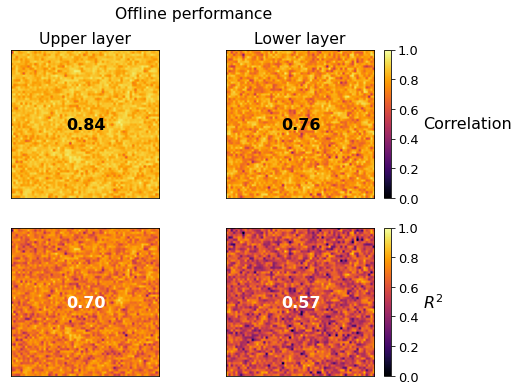

In [74]:
def imshow(arr):
    plt.imshow(arr, vmin=0, vmax=1, cmap='inferno')
    mean = arr.mean().data
    plt.text(32, 32, f"{mean:.2f}", color=('white' if mean<0.75 else 'black'),
             fontweight='bold', ha='center', va='center', fontsize=16)
    plt.xticks([]); plt.yticks([])
    
def colorbar(label):
    plt.colorbar().set_label(label, fontsize=16,rotation=0,ha='left',va='center')
    
fig = plt.figure(figsize=(7.6,6))
fig.suptitle("Offline performance")

for z in [0,1]:
    plt.subplot(2,2,z+1,title=f"{['Upper','Lower'][z]} layer")
    imshow(preds.q_subgrid_forcing_spatial_correlation.isel(lev=z))
    if z: colorbar("Correlation")
    
for z in [0,1]:
    plt.subplot(2,2,z+3)
    imshow(preds.q_subgrid_forcing_spatial_skill.isel(lev=z))
    if z: colorbar("$R^2$")

Offline performance is decent. How about online? Let's run a parameterized simulation:

In [ ]:
param_run = param.run_online(**json.loads(eddy_forcing1.pyqg_params))

Now let's compare its energy budget to that of a high-resolution and unparameterized low-resolution simulation:

In [85]:
hires = get_dataset('eddy/high_res').isel(run=0)
lores = get_dataset('eddy/low_res').isel(run=0)

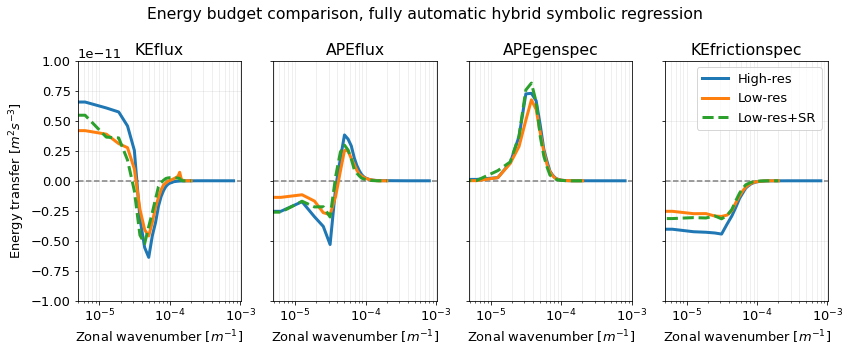

In [107]:
def energy_budget_figure(models):
    fig = plt.figure(figsize=(12,5))
    for i,term in enumerate(['KEflux','APEflux','APEgenspec','KEfrictionspec']):
        plt.subplot(1,4,i+1,title=term)
        plt.axhline(0,color='gray', ls='--')
        for model, label in models:
            plt.semilogx(model.k, model[term].sum('l'), label=label, lw=3, ls=('--' if 'SR' in label else '-')) 
        plt.ylim(-1e-11, 1e-11)
        plt.grid(which='both',alpha=0.25)
        if i == 0: plt.ylabel("Energy transfer $[m^2 s^{-3}]$")
        else: plt.yticks([-1e-11,-0.5e-11,0,0.5e-11,1e-11], ['']*5)
        if i == 3: plt.legend()
        plt.xlabel("Zonal wavenumber $[m^{-1}]$")
    plt.tight_layout()
    return fig

fig = energy_budget_figure([(hires, 'High-res'),(lores, 'Low-res'),(param_run,'Low-res+SR')])
fig.suptitle("Energy budget comparison, fully automatic hybrid symbolic regression")
plt.tight_layout()
plt.show()

This is not very good -- although we don't do worse than the low-res model, there isn't really much improvement.

However, it's a bit unrealistic to expect a fully automated symbolic regression procedure (trained only on offline data) to produce a model that performs well online, especially when we know there's significant randomness in many of the terms it discovers. Instead, we performed a semi-automated procedure, where a human decided to keep or discard each discovered term individually after each `gplearn` iteration, and sometimes added extensions of terms already discovered. We finally performed an ablation where we removed any terms whose removal didn't hurt online performance. This gives us a slightly different model:

$$
(w_1\nabla^2 + w_2\nabla^4 + w_3\nabla^6)(\overline{\mathbf{u}} \cdot \nabla)\overline{q} + (w_4\nabla^4 + w_5\nabla^6)\overline{q} + 
    (\overline{\mathbf{u}} \cdot \nabla)^2\nabla^2(w_6 \overline{u}_y + w_7 \overline{v}_x)
$$

We'll retrain the linear part of this model and evaluate it again here:

In [81]:
param2 = hybrid_symbolic.LinearSymbolicRegression.fit(
    eddy_forcing1, [
        'laplacian(advected(q))',
        'laplacian(laplacian(advected(q)))',
        'laplacian(laplacian(laplacian(advected(q))))',
        'laplacian(laplacian(q))',
        'laplacian(laplacian(laplacian(q)))',
        'advected(advected(ddx(laplacian(v))))',
        'advected(advected(ddy(laplacian(u))))'
    ])

In [ ]:
param2_run = param2.run_online(**json.loads(eddy_forcing1.pyqg_params))

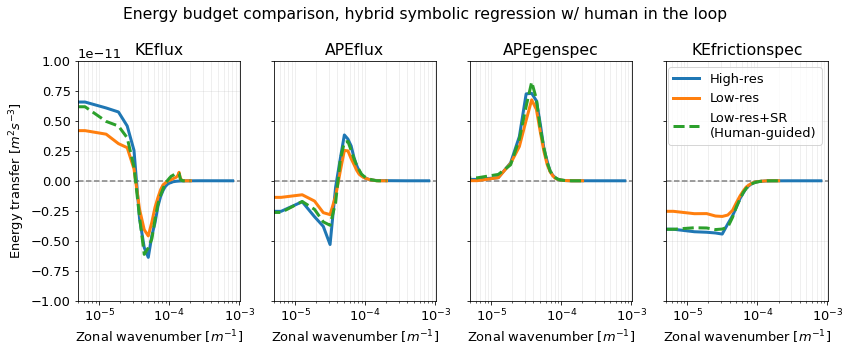

In [108]:
fig = energy_budget_figure([(hires, 'High-res'),(lores, 'Low-res'),(param2_run,'Low-res+SR\n(Human-guided)')])
fig.suptitle("Energy budget comparison, hybrid symbolic regression w/ human in the loop")
plt.tight_layout()
plt.show()

This parameterization leads to an energy budget that is much more similar to the high-res model (and appears fairly robust / able to generalize to new `pyqg` domains without retuning).

It's worth stressing that we make absolutely no claims that this parameterization is optimal, or that the expression will work in non-pseudospectral numerical settings (where it's also definitely much more computationally expensive). However, some parts of this parameterization may still be interesting to analyze, and we feel the larger methodological process is promising.